In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [5]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 100
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [6]:
from torch.utils.data import DataLoader

# Augmentation for the training dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Rotate images by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),  # Random crop with scaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# No augmentation for validation & test sets (only normalization)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets with appropriate transformations
train_dataset = DataClass(split='train', transform=train_transform, download=download)
validation_dataset = DataClass(split='val', transform=test_transform, download=download)
test_dataset = DataClass(split='test', transform=test_transform, download=download)

# Encapsulate datasets into DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 4708
Validation samples: 524
Test samples: 624


In [7]:
print(train_dataset)
print("===================")
print(validation_dataset)
print("===================")
print(test_dataset)

Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /home/oussama/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 524
    Root location: /home/oussama/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'nor

In [8]:
# visualization

train_dataset.montage(length=1)

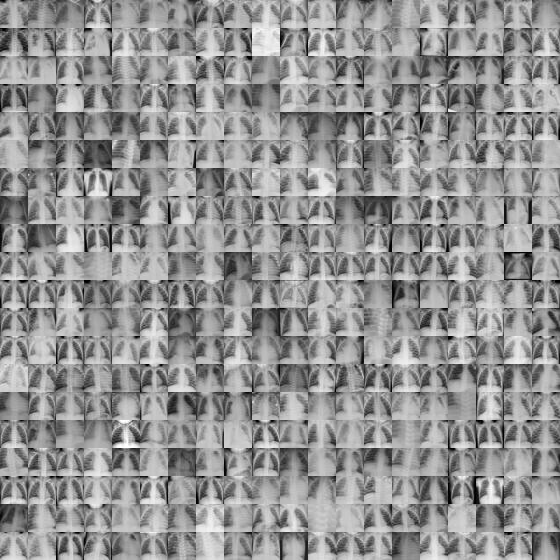

In [9]:
# montage

train_dataset.montage(length=20)

In [10]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [13]:
class M5(torch.nn.Module):
    def __init__(self, output=9):
        super(M5, self).__init__()
        # Layer 1
        self.Conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.ReLU1 = nn.ReLU()
        self.AvgPool1 = torch.nn.AvgPool2d(kernel_size = 2)
        # Layer 2
        self.Conv2 = torch.nn.Conv2d(in_channels=16, out_channels=64, kernel_size=4, stride=1, padding=0)
        self.ReLU2 = nn.ReLU()
        self.AvgPool2 = torch.nn.AvgPool2d(kernel_size = 2)
        # Layer 3
        self.Conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.ReLU3 = nn.ReLU()
        self.AvgPool3 = torch.nn.AvgPool2d(kernel_size = 3)
        self.Flatten = nn.ReLU()
        self.FC1 = torch.nn.Linear(1*1*128, output)


    def forward(self, x):
        out = self.Conv1(x)
        out = self.ReLU1(out)
        out = self.AvgPool1(out)
        out = self.Conv2(out)
        out = self.ReLU2(out)
        out = self.AvgPool2(out)
        out = self.Conv3(out)
        out = self.ReLU3(out)
        out = self.AvgPool3(out)
        out = self.Flatten(out)
        out = out.view(out.shape[0], -1)  # Fix flattening
        out = self.FC1(out)
        return out
    
model = M5(output=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [12]:
class Square(torch.nn.Module):
    def forward(self, x):
        return x**2
    
class Flatten(torch.nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)

In [20]:
class Lenet5(nn.Module):
    def __init__(self, outputs=2):
        super(Lenet5, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Reduce feature map size

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # Second pooling layer to further reduce size
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)  # ADDED: Extra pooling layer

        self.Flatten = Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=576, out_features=120)  # Reduced size
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Reduced size
        self.fc3 = nn.Linear(in_features=84, out_features=outputs)  # Reduced size

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.pool(output)

        output = self.conv2(output)
        output = self.relu2(output)
        output = self.pool2(output)  # Apply extra pooling layer

        output = self.Flatten(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output
    
model = Lenet5(outputs=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [21]:
# Initialize lists to store accuracy and loss
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [23]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    validation_correct = 0
    validation_total = 0
    running_loss = 0.0
    
    model.train()
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Training...")
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_correct += (predicted == targets).sum().item()
        train_total += targets.numel()


    train_accuracy = 100 * train_correct / train_total
    train_loss = running_loss / len(train_loader)

    # Store train loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long().to(device)
                loss = criterion(outputs, targets)
                predicted = torch.argmax(outputs, dim=1)

            validation_loss += loss.item()
            validation_correct += (predicted == targets).sum().item()
            validation_total += targets.numel()

        validation_accuracy = 100 * validation_correct / validation_total
        validation_loss /= len(test_loader)

    # Store test loss and accuracy
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"\nSummary: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%")



Epoch [1/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.85it/s]



Summary: Train Loss: 0.5480, Train Acc: 74.21%, Validation Loss: 0.5144, Validation Acc: 74.24%

Epoch [2/100] Training...


100%|██████████| 37/37 [00:02<00:00, 18.49it/s]



Summary: Train Loss: 0.5430, Train Acc: 74.21%, Validation Loss: 0.5107, Validation Acc: 74.24%

Epoch [3/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.05it/s]



Summary: Train Loss: 0.5378, Train Acc: 74.21%, Validation Loss: 0.5058, Validation Acc: 74.24%

Epoch [4/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.94it/s]



Summary: Train Loss: 0.5329, Train Acc: 74.21%, Validation Loss: 0.5005, Validation Acc: 74.24%

Epoch [5/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.85it/s]



Summary: Train Loss: 0.5293, Train Acc: 74.21%, Validation Loss: 0.4938, Validation Acc: 74.24%

Epoch [6/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.06it/s]



Summary: Train Loss: 0.5175, Train Acc: 74.21%, Validation Loss: 0.4855, Validation Acc: 74.24%

Epoch [7/100] Training...


100%|██████████| 37/37 [00:02<00:00, 18.38it/s]



Summary: Train Loss: 0.5101, Train Acc: 74.21%, Validation Loss: 0.4742, Validation Acc: 74.24%

Epoch [8/100] Training...


100%|██████████| 37/37 [00:01<00:00, 18.74it/s]



Summary: Train Loss: 0.4944, Train Acc: 74.21%, Validation Loss: 0.4588, Validation Acc: 74.24%

Epoch [9/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.77it/s]



Summary: Train Loss: 0.4748, Train Acc: 74.26%, Validation Loss: 0.4421, Validation Acc: 75.76%

Epoch [10/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.01it/s]



Summary: Train Loss: 0.4508, Train Acc: 75.51%, Validation Loss: 0.4130, Validation Acc: 80.15%

Epoch [11/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.98it/s]



Summary: Train Loss: 0.4244, Train Acc: 79.25%, Validation Loss: 0.3916, Validation Acc: 85.69%

Epoch [12/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.90it/s]



Summary: Train Loss: 0.3882, Train Acc: 83.73%, Validation Loss: 0.3584, Validation Acc: 87.98%

Epoch [13/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.94it/s]



Summary: Train Loss: 0.3512, Train Acc: 85.85%, Validation Loss: 0.3324, Validation Acc: 88.36%

Epoch [14/100] Training...


100%|██████████| 37/37 [00:01<00:00, 18.95it/s]



Summary: Train Loss: 0.3269, Train Acc: 87.45%, Validation Loss: 0.3160, Validation Acc: 88.36%

Epoch [15/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.24it/s]



Summary: Train Loss: 0.3068, Train Acc: 87.98%, Validation Loss: 0.3057, Validation Acc: 86.26%

Epoch [16/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.47it/s]



Summary: Train Loss: 0.2846, Train Acc: 88.91%, Validation Loss: 0.3011, Validation Acc: 86.45%

Epoch [17/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.16it/s]



Summary: Train Loss: 0.2761, Train Acc: 88.64%, Validation Loss: 0.2634, Validation Acc: 87.98%

Epoch [18/100] Training...


100%|██████████| 37/37 [00:02<00:00, 18.42it/s]



Summary: Train Loss: 0.2680, Train Acc: 88.85%, Validation Loss: 0.3244, Validation Acc: 85.69%

Epoch [19/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.75it/s]



Summary: Train Loss: 0.2637, Train Acc: 88.93%, Validation Loss: 0.2997, Validation Acc: 87.40%

Epoch [20/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.79it/s]



Summary: Train Loss: 0.2530, Train Acc: 89.61%, Validation Loss: 0.3223, Validation Acc: 85.50%

Epoch [21/100] Training...


100%|██████████| 37/37 [00:01<00:00, 18.84it/s]



Summary: Train Loss: 0.2438, Train Acc: 90.02%, Validation Loss: 0.3200, Validation Acc: 85.69%

Epoch [22/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.67it/s]



Summary: Train Loss: 0.2435, Train Acc: 90.12%, Validation Loss: 0.3128, Validation Acc: 86.07%

Epoch [23/100] Training...


100%|██████████| 37/37 [00:02<00:00, 18.03it/s]



Summary: Train Loss: 0.2456, Train Acc: 89.44%, Validation Loss: 0.2763, Validation Acc: 88.55%

Epoch [24/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.96it/s]



Summary: Train Loss: 0.2373, Train Acc: 90.46%, Validation Loss: 0.3130, Validation Acc: 86.45%

Epoch [25/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.98it/s]



Summary: Train Loss: 0.2354, Train Acc: 90.10%, Validation Loss: 0.3175, Validation Acc: 86.45%

Epoch [26/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.93it/s]



Summary: Train Loss: 0.2442, Train Acc: 89.49%, Validation Loss: 0.2973, Validation Acc: 87.60%

Epoch [27/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.50it/s]



Summary: Train Loss: 0.2298, Train Acc: 90.53%, Validation Loss: 0.2583, Validation Acc: 89.31%

Epoch [28/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.10it/s]



Summary: Train Loss: 0.2405, Train Acc: 89.76%, Validation Loss: 0.2675, Validation Acc: 88.36%

Epoch [29/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.00it/s]



Summary: Train Loss: 0.2231, Train Acc: 90.99%, Validation Loss: 0.3003, Validation Acc: 87.40%

Epoch [30/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.89it/s]



Summary: Train Loss: 0.2322, Train Acc: 90.36%, Validation Loss: 0.2195, Validation Acc: 91.22%

Epoch [31/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.24it/s]



Summary: Train Loss: 0.2296, Train Acc: 90.89%, Validation Loss: 0.3459, Validation Acc: 86.07%

Epoch [32/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.61it/s]



Summary: Train Loss: 0.2302, Train Acc: 90.59%, Validation Loss: 0.3207, Validation Acc: 86.64%

Epoch [33/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.49it/s]



Summary: Train Loss: 0.2353, Train Acc: 90.14%, Validation Loss: 0.2324, Validation Acc: 90.27%

Epoch [34/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.15it/s]



Summary: Train Loss: 0.2242, Train Acc: 90.74%, Validation Loss: 0.2772, Validation Acc: 87.98%

Epoch [35/100] Training...


100%|██████████| 37/37 [00:01<00:00, 18.94it/s]



Summary: Train Loss: 0.2335, Train Acc: 90.46%, Validation Loss: 0.2996, Validation Acc: 87.02%

Epoch [36/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.48it/s]



Summary: Train Loss: 0.2315, Train Acc: 90.74%, Validation Loss: 0.2720, Validation Acc: 88.36%

Epoch [37/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.50it/s]



Summary: Train Loss: 0.2307, Train Acc: 90.80%, Validation Loss: 0.2295, Validation Acc: 89.69%

Epoch [38/100] Training...


100%|██████████| 37/37 [00:02<00:00, 18.31it/s]



Summary: Train Loss: 0.2328, Train Acc: 90.57%, Validation Loss: 0.2502, Validation Acc: 89.31%

Epoch [39/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.94it/s]



Summary: Train Loss: 0.2280, Train Acc: 90.53%, Validation Loss: 0.3348, Validation Acc: 86.26%

Epoch [40/100] Training...


100%|██████████| 37/37 [00:02<00:00, 17.90it/s]



Summary: Train Loss: 0.2280, Train Acc: 90.31%, Validation Loss: 0.2126, Validation Acc: 91.22%

Epoch [41/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.06it/s]



Summary: Train Loss: 0.2236, Train Acc: 90.99%, Validation Loss: 0.2157, Validation Acc: 90.65%

Epoch [42/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.58it/s]



Summary: Train Loss: 0.2341, Train Acc: 89.91%, Validation Loss: 0.2478, Validation Acc: 89.31%

Epoch [43/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.05it/s]



Summary: Train Loss: 0.2274, Train Acc: 90.80%, Validation Loss: 0.2747, Validation Acc: 87.79%

Epoch [44/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.00it/s]



Summary: Train Loss: 0.2258, Train Acc: 90.80%, Validation Loss: 0.2659, Validation Acc: 88.55%

Epoch [45/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.01it/s]



Summary: Train Loss: 0.2254, Train Acc: 91.04%, Validation Loss: 0.2570, Validation Acc: 88.93%

Epoch [46/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.93it/s]



Summary: Train Loss: 0.2288, Train Acc: 90.70%, Validation Loss: 0.2293, Validation Acc: 89.69%

Epoch [47/100] Training...


100%|██████████| 37/37 [00:01<00:00, 18.92it/s]



Summary: Train Loss: 0.2248, Train Acc: 90.53%, Validation Loss: 0.2332, Validation Acc: 89.69%

Epoch [48/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.97it/s]



Summary: Train Loss: 0.2148, Train Acc: 91.42%, Validation Loss: 0.2386, Validation Acc: 89.31%

Epoch [49/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.03it/s]



Summary: Train Loss: 0.2242, Train Acc: 90.85%, Validation Loss: 0.2225, Validation Acc: 89.89%

Epoch [50/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.03it/s]



Summary: Train Loss: 0.2230, Train Acc: 91.10%, Validation Loss: 0.2741, Validation Acc: 87.79%

Epoch [51/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.74it/s]



Summary: Train Loss: 0.2213, Train Acc: 90.97%, Validation Loss: 0.2144, Validation Acc: 90.65%

Epoch [52/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.85it/s]



Summary: Train Loss: 0.2160, Train Acc: 90.93%, Validation Loss: 0.2516, Validation Acc: 88.93%

Epoch [53/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.70it/s]



Summary: Train Loss: 0.2137, Train Acc: 91.46%, Validation Loss: 0.2822, Validation Acc: 87.40%

Epoch [54/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.11it/s]



Summary: Train Loss: 0.2292, Train Acc: 90.87%, Validation Loss: 0.2977, Validation Acc: 87.21%

Epoch [55/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.45it/s]



Summary: Train Loss: 0.2186, Train Acc: 90.89%, Validation Loss: 0.2696, Validation Acc: 87.98%

Epoch [56/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.10it/s]



Summary: Train Loss: 0.2170, Train Acc: 91.61%, Validation Loss: 0.2275, Validation Acc: 90.08%

Epoch [57/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.00it/s]



Summary: Train Loss: 0.2214, Train Acc: 91.33%, Validation Loss: 0.2564, Validation Acc: 88.36%

Epoch [58/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.99it/s]



Summary: Train Loss: 0.2239, Train Acc: 90.61%, Validation Loss: 0.1948, Validation Acc: 91.41%

Epoch [59/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.97it/s]



Summary: Train Loss: 0.2188, Train Acc: 90.65%, Validation Loss: 0.3162, Validation Acc: 85.88%

Epoch [60/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.15it/s]



Summary: Train Loss: 0.2257, Train Acc: 90.76%, Validation Loss: 0.2619, Validation Acc: 88.93%

Epoch [61/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.94it/s]



Summary: Train Loss: 0.2189, Train Acc: 91.36%, Validation Loss: 0.2967, Validation Acc: 87.60%

Epoch [62/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.48it/s]



Summary: Train Loss: 0.2197, Train Acc: 91.40%, Validation Loss: 0.2575, Validation Acc: 88.93%

Epoch [63/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.35it/s]



Summary: Train Loss: 0.2153, Train Acc: 91.42%, Validation Loss: 0.2837, Validation Acc: 87.79%

Epoch [64/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.02it/s]



Summary: Train Loss: 0.2159, Train Acc: 91.27%, Validation Loss: 0.2562, Validation Acc: 89.31%

Epoch [65/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.98it/s]



Summary: Train Loss: 0.2115, Train Acc: 91.33%, Validation Loss: 0.2670, Validation Acc: 88.93%

Epoch [66/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.41it/s]



Summary: Train Loss: 0.2156, Train Acc: 91.36%, Validation Loss: 0.2113, Validation Acc: 91.41%

Epoch [67/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.19it/s]



Summary: Train Loss: 0.2164, Train Acc: 91.12%, Validation Loss: 0.2560, Validation Acc: 88.93%

Epoch [68/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.39it/s]



Summary: Train Loss: 0.2216, Train Acc: 91.10%, Validation Loss: 0.2974, Validation Acc: 87.02%

Epoch [69/100] Training...


100%|██████████| 37/37 [00:01<00:00, 18.80it/s]



Summary: Train Loss: 0.2126, Train Acc: 91.74%, Validation Loss: 0.1825, Validation Acc: 91.60%

Epoch [70/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.05it/s]



Summary: Train Loss: 0.2201, Train Acc: 91.04%, Validation Loss: 0.2445, Validation Acc: 88.93%

Epoch [71/100] Training...


100%|██████████| 37/37 [00:01<00:00, 18.91it/s]



Summary: Train Loss: 0.2146, Train Acc: 91.53%, Validation Loss: 0.3600, Validation Acc: 84.73%

Epoch [72/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.30it/s]



Summary: Train Loss: 0.2135, Train Acc: 91.84%, Validation Loss: 0.2379, Validation Acc: 89.31%

Epoch [73/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.13it/s]



Summary: Train Loss: 0.2198, Train Acc: 91.38%, Validation Loss: 0.2326, Validation Acc: 89.50%

Epoch [74/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.06it/s]



Summary: Train Loss: 0.2108, Train Acc: 91.46%, Validation Loss: 0.3224, Validation Acc: 85.50%

Epoch [75/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.95it/s]



Summary: Train Loss: 0.2048, Train Acc: 92.12%, Validation Loss: 0.2488, Validation Acc: 88.93%

Epoch [76/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.66it/s]



Summary: Train Loss: 0.2265, Train Acc: 90.72%, Validation Loss: 0.1866, Validation Acc: 91.79%

Epoch [77/100] Training...


100%|██████████| 37/37 [00:01<00:00, 18.97it/s]



Summary: Train Loss: 0.2259, Train Acc: 90.95%, Validation Loss: 0.2932, Validation Acc: 87.02%

Epoch [78/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.53it/s]



Summary: Train Loss: 0.2139, Train Acc: 91.50%, Validation Loss: 0.2765, Validation Acc: 87.98%

Epoch [79/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.89it/s]



Summary: Train Loss: 0.2135, Train Acc: 91.40%, Validation Loss: 0.2526, Validation Acc: 88.36%

Epoch [80/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.56it/s]



Summary: Train Loss: 0.2099, Train Acc: 91.31%, Validation Loss: 0.2581, Validation Acc: 88.17%

Epoch [81/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.96it/s]



Summary: Train Loss: 0.2158, Train Acc: 91.48%, Validation Loss: 0.4144, Validation Acc: 82.44%

Epoch [82/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.54it/s]



Summary: Train Loss: 0.2155, Train Acc: 91.36%, Validation Loss: 0.2263, Validation Acc: 89.50%

Epoch [83/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.39it/s]



Summary: Train Loss: 0.2136, Train Acc: 91.59%, Validation Loss: 0.2166, Validation Acc: 90.65%

Epoch [84/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.47it/s]



Summary: Train Loss: 0.2110, Train Acc: 91.27%, Validation Loss: 0.3022, Validation Acc: 86.07%

Epoch [85/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.00it/s]



Summary: Train Loss: 0.2067, Train Acc: 91.80%, Validation Loss: 0.2633, Validation Acc: 87.98%

Epoch [86/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.61it/s]



Summary: Train Loss: 0.2092, Train Acc: 91.53%, Validation Loss: 0.2936, Validation Acc: 86.45%

Epoch [87/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.26it/s]



Summary: Train Loss: 0.2149, Train Acc: 91.46%, Validation Loss: 0.3181, Validation Acc: 85.50%

Epoch [88/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.13it/s]



Summary: Train Loss: 0.2142, Train Acc: 91.48%, Validation Loss: 0.2300, Validation Acc: 89.69%

Epoch [89/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.73it/s]



Summary: Train Loss: 0.2125, Train Acc: 92.08%, Validation Loss: 0.2320, Validation Acc: 89.31%

Epoch [90/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.60it/s]



Summary: Train Loss: 0.2199, Train Acc: 91.40%, Validation Loss: 0.1787, Validation Acc: 91.98%

Epoch [91/100] Training...


100%|██████████| 37/37 [00:01<00:00, 18.65it/s]



Summary: Train Loss: 0.2026, Train Acc: 92.14%, Validation Loss: 0.3199, Validation Acc: 85.50%

Epoch [92/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.88it/s]



Summary: Train Loss: 0.2111, Train Acc: 91.48%, Validation Loss: 0.2499, Validation Acc: 88.55%

Epoch [93/100] Training...


100%|██████████| 37/37 [00:01<00:00, 20.03it/s]



Summary: Train Loss: 0.2090, Train Acc: 91.91%, Validation Loss: 0.2730, Validation Acc: 87.79%

Epoch [94/100] Training...


100%|██████████| 37/37 [00:01<00:00, 18.69it/s]



Summary: Train Loss: 0.2066, Train Acc: 91.84%, Validation Loss: 0.2438, Validation Acc: 88.74%

Epoch [95/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.17it/s]



Summary: Train Loss: 0.2144, Train Acc: 91.57%, Validation Loss: 0.2227, Validation Acc: 90.08%

Epoch [96/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.69it/s]



Summary: Train Loss: 0.2120, Train Acc: 91.53%, Validation Loss: 0.2702, Validation Acc: 88.17%

Epoch [97/100] Training...


100%|██████████| 37/37 [00:01<00:00, 18.75it/s]



Summary: Train Loss: 0.2035, Train Acc: 91.25%, Validation Loss: 0.2492, Validation Acc: 88.93%

Epoch [98/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.59it/s]



Summary: Train Loss: 0.2056, Train Acc: 91.91%, Validation Loss: 0.1440, Validation Acc: 93.89%

Epoch [99/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.50it/s]



Summary: Train Loss: 0.2056, Train Acc: 92.12%, Validation Loss: 0.2600, Validation Acc: 87.98%

Epoch [100/100] Training...


100%|██████████| 37/37 [00:01<00:00, 19.55it/s]


Summary: Train Loss: 0.1991, Train Acc: 91.82%, Validation Loss: 0.2007, Validation Acc: 91.60%


ValueError: x and y must have same first dimension, but have shapes (100,) and (112,)

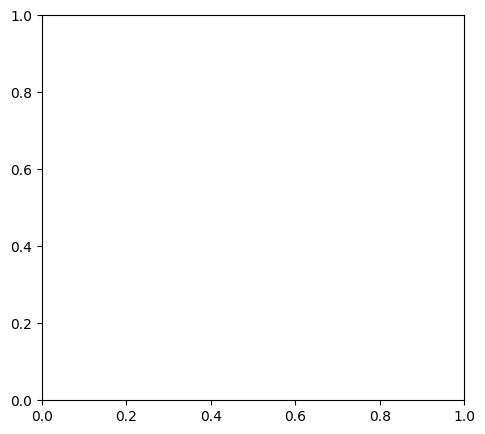

In [24]:
# Plot accuracy and loss curves
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, validation_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [25]:
# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

print("\nTesting the model on the test dataset...")
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, targets in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)

        test_loss += loss.item()
        test_correct += (predicted == targets).sum().item()
        test_total += targets.numel()

# Compute final test accuracy and loss
test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"\nFinal Test Results: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")


Testing the model on the test dataset...

Final Test Results: Loss: 0.3428, Accuracy: 88.62%


In [26]:
# Save the trained model
MODEL_PATH = "pneumonia_model.pth"
torch.save(model, MODEL_PATH)

print(f"Model saved successfully as {MODEL_PATH}!")

Model saved successfully as pneumonia_model.pth!
